In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [2]:
%load_ext autoreload
%autoreload 2
from dataset import *
from video import SimulationVideo
from video import NuscenesVideo, NuscenesVideoDebug, PFVideo
from MapMatching import MapMatching

In [3]:
import copy
class Simulation():
    def __init__(self, model, **kwargs):
        pass
    
    def run(self, N):
        pass
    
class DynamicSimulation():
    def __init__(self, model, **kwargs):
        self.model = model
        self.dataset = DynamicSimulatedDataset()
        self.video = SimulationVideo()
    
    def run(self, N):
        for t in range(0,N):
            print(f"frame {t}")
            zw, covw, prior, video_data = self.dataset.getData(t)
            print("prior", prior)
            points, polynoms = self.model.run(zw,covw,prior)
            self.video.save(t, prior, video_data, points, polynoms, self.model.getDebugInfo())
            
class NuscenesSimulation():
    def __init__(self, model, scene_id=5, **kwargs):
        self.model = model
        directory = kwargs.pop('directory', r"/home/kfir/workspace/nuScenes/v1.0-trainval")
        self.mm = kwargs.pop('mm', False)
        self.dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=scene_id)
        #self.video = NuscenesVideo(history=True, scene=scene)
        self.video_debug = NuscenesVideoDebug(history=True, scene=scene)
        self.pf_video = PFVideo(history=True, scene=scene)
        self.map_matching = MapMatching(N=200)
        self.lane = None
        self.scene = scene
        
    def getBestLane(self, prior):
        if self.lane is None:
                self.lane = prior[0]
                lane = prior[0]
        else:
            for pr in prior:
                if 1:#if np.linalg.norm(self.lane["poly"][1]-pr["poly"][1]) < 2 and np.linalg.norm(self.lane["poly"][0]-pr["poly"][0]) < 0.1:
                    lane = pr
                    self.lane = pr

        lanes = [lane]
        return lanes
    
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
        
    def run(self,start, N, generate_video=False, video_with_priors=False, debug=False, translate=True):
        start_idx = start
        first = True
        for t in range(start_idx,start_idx + N):
            print(f"frame {t}")
            zw, covw, prior, video_data, nusc_map = self.dataset.getData(t)
            if first:
                translation = np.array(video_data["pos"][0:2])
                print("translation", translation)
                first = False
                
            #lanes = self.getBestLane(prior)
            lanes = copy.deepcopy(prior)
            if translate:
                lanes = self.translatePrior(translation, lanes)
                zw = self.translateMeasurements(zw, translation)
            prior_list = []
            for lane in lanes:
                (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
                prior_list.append({"c": (a0,a1,a2), "xmin": np.min(lane["x"]), "xmax": np.max(lane["x"])})
    
            points, polynoms = self.model.run(zw,covw,prior_list)
            if translate:
                points, polynoms = self.translateOutput(points, polynoms, -1*translation)
                
            #Run map-matching!
            if self.mm:
                extended_tracks = self.model.getExtendedTracks()
                orig_world_ref = video_data["pos"]
                world_ref = np.array([orig_world_ref[0]-translation[0], orig_world_ref[1]-translation[1]]) 
                self.map_matching.run(extended_tracks, nusc_map, orig_world_ref, world_ref, video_data["rot"], video_data["heading"], video_data["odometry"])
            
            try:
                self.video.save(t,video_data, polynoms, nusc_map, video_with_priors=video_with_priors)
            except:
                pass
            try:
                self.video_debug.save(t,video_data, polynoms,points, nusc_map,self.model.getDebugInfo(), video_with_priors=video_with_priors)
            except:
                pass
            try:
                mm_results = self.map_matching.getResults()
                mm_results["pf_best_pos"] += translation[0:2]
                mm_results["pf_mean_pos"] += translation[0:2]
                print(mm_results)
                self.pf_video.save(t,video_data, mm_results, polynoms, nusc_map)
            except:
                pass
        
        if generate_video:
            try:
                self.video.generate(name=f"video\scene{self.scene}.avi", fps=5)
            except:
                pass
            try:
                self.video_debug.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass
            try:
                self.pf_video.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass

scene_id=426 scene_name=scene-0536 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


frame 90
translation [309.1440058 668.7799789]
Number of point tracks before run() 0
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': array([309.16701175, 668.82557758]), 'pf_best_theta': 2.662673096259229, 'pf_mean_pos': array([309.14173517, 668.77783326]), 'pf_mean_theta': 2.662673096259241}


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 91
Number of point tracks before run() 55
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': array([309.24000836, 668.87167487]), 'pf_best_theta': 2.662558240390121, 'pf_mean_pos': array([309.13941677, 668.76139493]), 'pf_mean_theta': 2.6625582403718813}


/home/kfir/workspace/RadarLocalization/tracker.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame 92
Number of point tracks before run() 61
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': array([309.35982428, 668.46211776]), 'pf_best_theta': 2.662631746628371, 'pf_mean_pos': array([309.15635576, 668.74631796]), 'pf_mean_theta': 2.6626317626123153}
frame 93
Number of point tracks before run() 67
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': array([309.30187898, 668.46216229]), 'pf_best_theta': 2.662486902839982, 'pf_mean_pos': array([309.15280294, 668.74008041]), 'pf_mean_theta': 2.662486932656941}
frame 94
Number of point tracks before run() 85
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': array([309.20132748, 668.55714408]), 'pf_best_theta': 2.6621339947691043, 'pf_mean_pos': array([309.16198735, 668.70922759]), 'pf_mean_theta': 2.6621340304043355}
frame 95
Number of point tracks before run() 94
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': ar

/home/kfir/workspace/RadarLocalization/tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


len(unique_polynoms) 1
{'pf_best_pos': array([308.97722911, 668.64658225]), 'pf_best_theta': 2.6595125290859754, 'pf_mean_pos': array([309.09081883, 668.74263692]), 'pf_mean_theta': 2.659512540201023}
frame 99
Number of point tracks before run() 103
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 1
{'pf_best_pos': array([308.65093008, 668.75525424]), 'pf_best_theta': 2.657129032267658, 'pf_mean_pos': array([308.9870628 , 668.80111259]), 'pf_mean_theta': 2.657129054978359}
frame 100
Number of point tracks before run() 96
Number of extended tracks before run() 1
len(unique_polynoms) 0
{'pf_best_pos': array([308.51019652, 668.81678412]), 'pf_best_theta': 2.6558714440568316, 'pf_mean_pos': array([308.93704793, 668.81418388]), 'pf_mean_theta': 2.655871474671234}
frame 101
Number of point tracks before run() 97
Number of extended tracks before run() 1
Updating extended ob

len(unique_polynoms) 2
{'pf_best_pos': array([306.18833424, 670.57606475]), 'pf_best_theta': 2.6385989976898845, 'pf_mean_pos': array([306.87416732, 669.90478031]), 'pf_mean_theta': 2.638599095069062}
frame 114
Number of point tracks before run() 108
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
{'pf_best_pos': array([306.05707946, 670.35884084]), 'pf_best_theta': 2.6372033217857105, 'pf_mean_pos': array([306.69699941, 670.0025737 ]), 'pf_mean_theta': 2.637203424543516}
frame 115
Number of point tracks before run() 113
Number of extended tracks

frame 131
Number of point tracks before run() 111
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
len(unique_polynoms) 2
{'pf_best_pos': array([301.56245705, 672.4281629 ]), 'pf_best_theta': 2.3785891663677425, 'pf_mean_pos': array([302.2639882 , 673.12901962]), 'pf_mean_theta': 2.378589279042995}
frame 132
Number of point tracks before run() 116
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
len(unique_polynoms) 2
{'pf_best_pos': array([301.43059538, 672.54149017]), 'pf_best_theta': 2.3550814008857612, 'pf_mean_pos': array([302.05642812, 673.33645172]), 'pf_mean_theta': 2.3550815042787754}
frame 133
Number of point tracks before run() 110
Number of extended tracks before run() 2


{'pf_best_pos': array([299.55390159, 679.76457053]), 'pf_best_theta': 1.5859186786482695, 'pf_mean_pos': array([299.50650245, 680.21892096]), 'pf_mean_theta': 1.5859187743042198}
frame 155
Number of point tracks before run() 60
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': array([299.66139227, 680.0098565 ]), 'pf_best_theta': 1.5573969012959807, 'pf_mean_pos': array([299.5173885 , 680.51878282]), 'pf_mean_theta': 1.557396980363921}
frame 156
Number of point tracks before run() 64
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': array([299.69462759, 680.07570858]), 'pf_best_theta': 1.5296575330468363, 'pf_mean_pos': array([299.54487121, 680.80356346]), 'pf_mean_theta': 1.5296576003787827}
frame 157
Number of point tracks before run() 69
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': array([299.87772287, 680.44226242]), 'pf_best_theta': 1.5047359794711426, 'pf_mean_pos': array([299.55717549,

len(unique_polynoms) 1
{'pf_best_pos': array([302.46631207, 687.25137044]), 'pf_best_theta': 0.94456992061001, 'pf_mean_pos': array([302.77446802, 688.4103232 ]), 'pf_mean_theta': 0.9445700247109563}
frame 181
Number of point tracks before run() 109
Number of extended tracks before run() 2
Updating extended object track =  1
len(unique_polynoms) 1
{'pf_best_pos': array([302.57976577, 687.80617942]), 'pf_best_theta': 0.9291708407819588, 'pf_mean_pos': array([303.18449992, 688.93456025]), 'pf_mean_theta': 0.9291709455328052}
frame 182
Number of point tracks before run() 110
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
len(unique_polynoms) 2
{'pf_best_pos': array([302.91000745, 688.14084606]), 'pf_best_theta': 0.9226293727843409, 'pf_mean_pos': array([303.36682097, 689.18236404]), 'pf_mean_theta': 0.9226294737621704}
frame 183
Number of point tracks before run() 99
Number of extended tracks before run() 3
Updating extende

len(unique_polynoms) 1
{'pf_best_pos': array([303.96918678, 695.58054422]), 'pf_best_theta': 0.8771320511883731, 'pf_mean_pos': array([304.18420271, 696.69022026]), 'pf_mean_theta': 0.877132065690447}
frame 201
Number of point tracks before run() 151
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
len(unique_polynoms) 1
{'pf_best_pos': array([304.15856555, 695.77594021]), 'pf_best_theta': 0.875285228486514, 'pf_mean_pos': array([304.42651677, 696.98523786]), 'pf_mean_theta': 0.8752852459673756}
frame 202
Number of point tracks before run() 149
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
len(unique_polynoms) 2
{'pf_best_pos': array([304.46034266, 696.2006088 ]), 'pf_best_theta': 0.8732851845035903, 'pf_mean_pos': array([304.71717277, 697.32033789]), 'pf_mean_theta': 0.8732851971818922}
frame 203
Number of point tracks before run() 144
Number of extended t

len(unique_polynoms) 0
{'pf_best_pos': array([311.07724898, 706.21549034]), 'pf_best_theta': 0.849978656417008, 'pf_mean_pos': array([312.32162943, 706.96866567]), 'pf_mean_theta': 0.8499785159535977}
frame 224
Number of point tracks before run() 113
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  2
len(unique_polynoms) 2
{'pf_best_pos': array([311.32180545, 705.89654419]), 'pf_best_theta': 0.8510181924008897, 'pf_mean_pos': array([312.48214222, 707.19609323]), 'pf_mean_theta': 0.8510183605872268}
frame 225
Number of point tracks before run() 112
Number of extended tracks before run() 3
Updating extended object track =  1
len(unique_polynoms) 1
{'pf_best_pos': array([311.5230712 , 706.28022686]), 'pf_best_theta': 0.8515198708293514, 'pf_mean_pos': array([312.71575138, 707.49518549]), 'pf_mean_theta': 0.8515200650824437}
frame 226
Number of point tracks before run() 107
Number of extended tracks before run() 3
Updating exten

len(unique_polynoms) 1
{'pf_best_pos': array([324.6209988 , 719.20252169]), 'pf_best_theta': 0.877326073705003, 'pf_mean_pos': array([323.80077587, 719.17214519]), 'pf_mean_theta': 0.8773262530881951}
frame 248
Number of point tracks before run() 128
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
{'pf_best_pos': array([323.20915961, 718.26953321]), 'pf_best_theta': 0.8782961820311668, 'pf_mean_pos': array([324.0737491 , 719.48447026]), 'pf_mean_theta': 0.8782960105773864}
frame 249
Number of point tracks before run() 134
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 2
{'pf_best_pos': array([323.17527309, 720.15182215]), 'pf_best_theta': 0.8795371079308296, 'pf_mean_pos': array([324.2980727 , 719.85149086]), 'pf_mean_theta': 0.879536904641165

frame 270
Number of point tracks before run() 119
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
len(unique_polynoms) 2
{'pf_best_pos': array([333.56876532, 729.24583554]), 'pf_best_theta': 0.8936377941674172, 'pf_mean_pos': array([332.16498689, 728.94869369]), 'pf_mean_theta': 0.8936376648113913}
frame 271
Number of point tracks before run() 108
Number of extended tracks before run() 4
len(unique_polynoms) 0
{'pf_best_pos': array([334.36347572, 730.17027559]), 'pf_best_theta': 0.8947922094746028, 'pf_mean_pos': array([332.42442899, 729.30310745]), 'pf_mean_theta': 0.8947923775640086}
frame 272
Number of point tracks before run() 112
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
{'pf_best_pos': array([332.94781565, 729.43869645]), 'pf_best_theta': 0.895292319178

len(unique_polynoms) 2
{'pf_best_pos': array([340.32637549, 738.94554489]), 'pf_best_theta': 0.9124247218758894, 'pf_mean_pos': array([338.15241959, 736.76516283]), 'pf_mean_theta': 0.9124246106251027}
frame 293
Number of point tracks before run() 109
Number of extended tracks before run() 3
Updating extended object track =  2
len(unique_polynoms) 1
{'pf_best_pos': array([335.85499989, 737.00603786]), 'pf_best_theta': 0.9107277980362998, 'pf_mean_pos': array([338.32226138, 737.04444702]), 'pf_mean_theta': 0.9107275482897254}
frame 294
Number of point tracks before run() 102
Number of extended tracks before run() 3
Updating extended object track =  0
len(unique_polynoms) 1
{'pf_best_pos': array([337.67777046, 738.18905403]), 'pf_best_theta': 0.9102593927848313, 'pf_mean_pos': array([338.62138863, 737.64797769]), 'pf_mean_theta': 0.910259186934882}
frame 295
Number of point tracks before run() 101
Number of extended tracks before run() 3
Updating extended object track =  0
Updating exten

Number of point tracks before run() 95
Number of extended tracks before run() 3
Updating extended object track =  1
len(unique_polynoms) 1
{'pf_best_pos': array([342.61128443, 744.0379943 ]), 'pf_best_theta': 0.8198040165435243, 'pf_mean_pos': array([342.6488329 , 743.62782011]), 'pf_mean_theta': 0.8198038877517252}
frame 317
Number of point tracks before run() 85
Number of extended tracks before run() 3
len(unique_polynoms) 0
{'pf_best_pos': array([341.17311316, 742.89251873]), 'pf_best_theta': 0.8262161376520432, 'pf_mean_pos': array([342.87277429, 743.99745993]), 'pf_mean_theta': 0.8262160922130048}
frame 318
Number of point tracks before run() 88
Number of extended tracks before run() 3
len(unique_polynoms) 0
{'pf_best_pos': array([342.4942044 , 743.25550845]), 'pf_best_theta': 0.8305712341005003, 'pf_mean_pos': array([342.9875879 , 744.18109451]), 'pf_mean_theta': 0.8305710666303189}
frame 319
Number of point tracks before run() 88
Number of extended tracks before run() 3
Updating

Number of point tracks before run() 106
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': array([349.22073429, 751.39925492]), 'pf_best_theta': 1.1114333016097913, 'pf_mean_pos': array([346.54831755, 749.56321766]), 'pf_mean_theta': 1.111433577749457}
frame 345
Number of point tracks before run() 113
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': array([349.27599982, 751.58586455]), 'pf_best_theta': 1.1164276059341356, 'pf_mean_pos': array([346.61796491, 749.69525147]), 'pf_mean_theta': 1.1164278791032536}
frame 346
Number of point tracks before run() 113
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': array([349.5603249 , 751.86979444]), 'pf_best_theta': 1.1206696132233853, 'pf_mean_pos': array([346.70425594, 749.84428356]), 'pf_mean_theta': 1.1206698796781607}
frame 347
Number of point tracks before run() 116
Number of extended tracks before run() 0
len(unique_polynoms) 0
{'pf_best_pos': ar

Number of point tracks before run() 86
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
{'pf_best_pos': array([346.5415138 , 753.03561063]), 'pf_best_theta': 1.2841273570169163, 'pf_mean_pos': array([345.94743238, 753.14343383]), 'pf_mean_theta': 1.284127720992375}
frame 372
Number of point tracks before run() 84
Number of extended tracks before run() 2
len(unique_polynoms) 0
{'pf_best_pos': array([345.27010886, 752.99959112]), 'pf_best_theta': 1.2940732899900755, 'pf_mean_pos': array([345.93182195, 753.25246449]), 'pf_mean_theta': 1.2940736689214167}
frame 373
Number of point tracks before run() 86
Number of extended tracks before run() 2
Updating extended object track =  0
len(unique_polynoms) 1
{'pf_best_pos': array([344.71163654, 751.67851418]), 'pf_best_theta': 1.314219321451012, 'pf_mean_pos': array([345.93609328, 753.55681308]), 'pf_mean_theta': 1.3142192598536873}
frame 374
Number of point tr

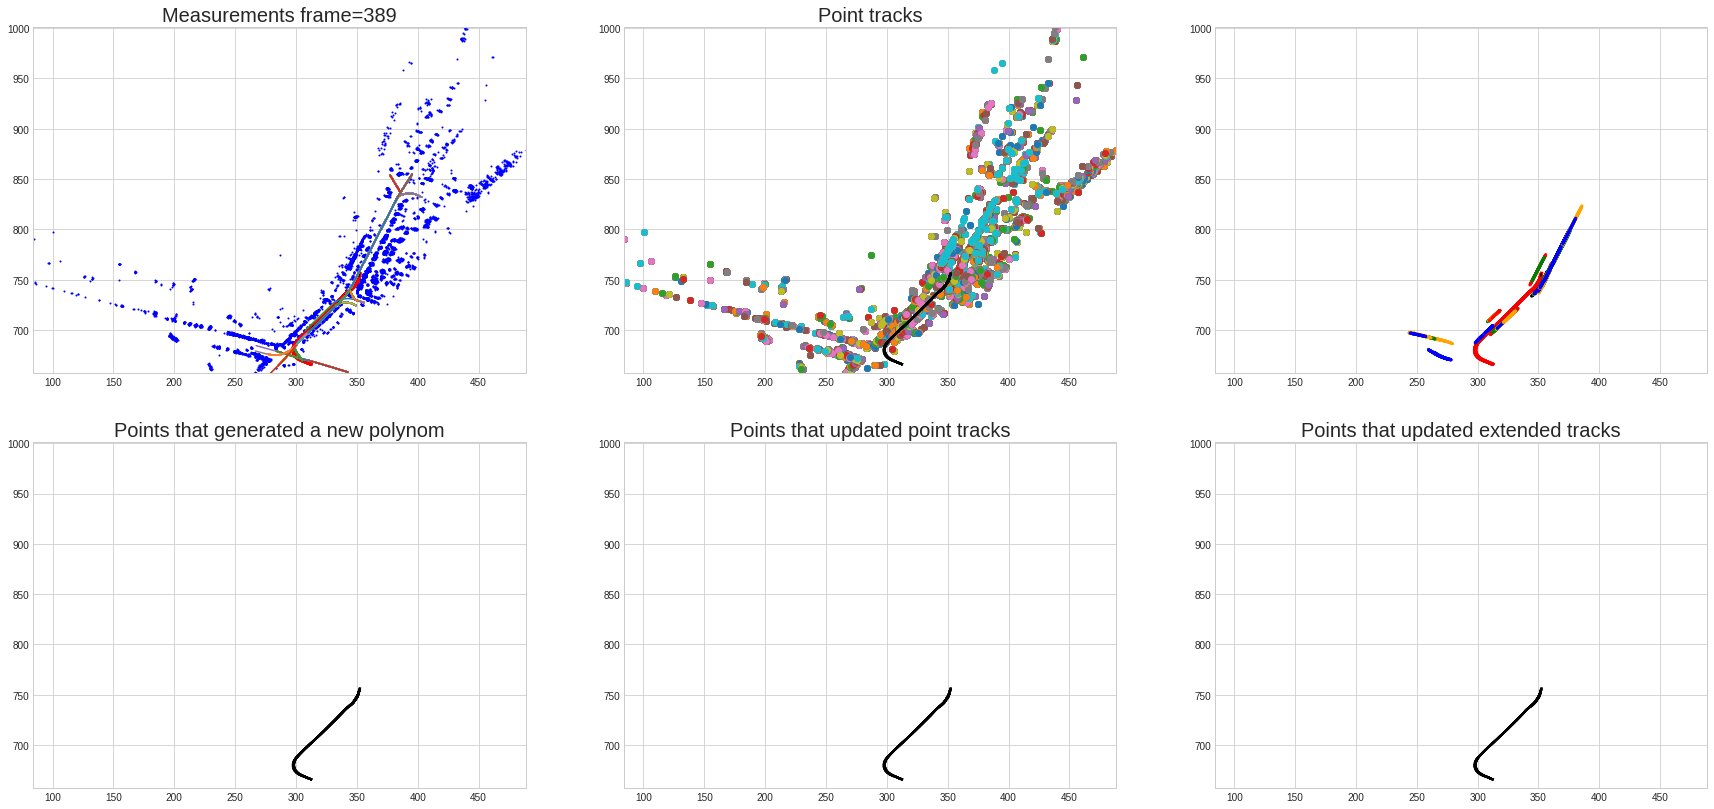

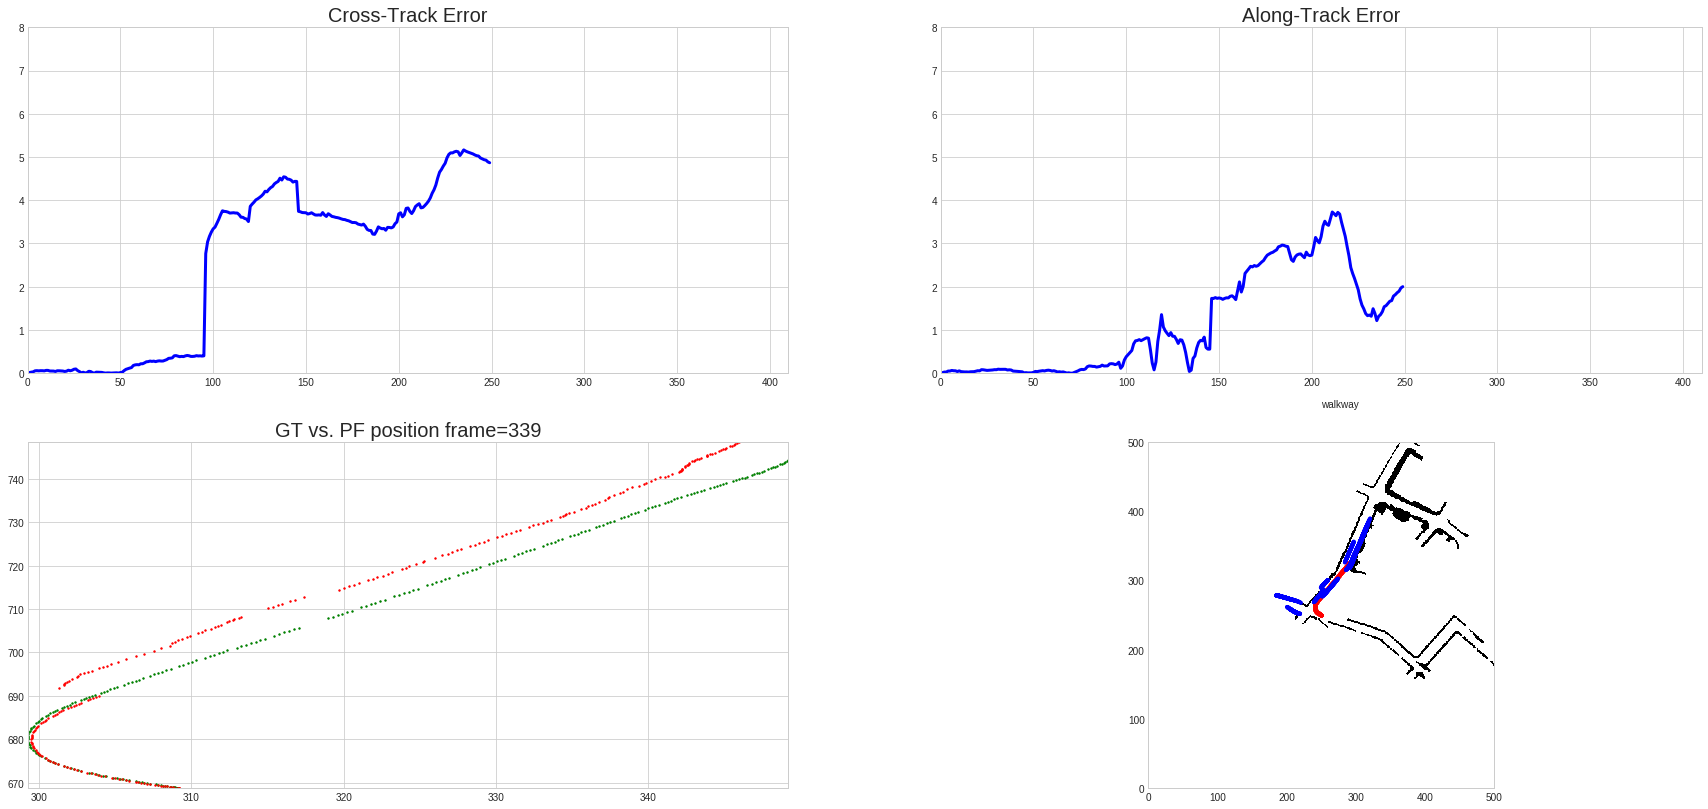

In [4]:
from tracker import Tracker
model = Tracker()
#sim = DynamicSimulation(model)
scene = 426
sim = NuscenesSimulation(model,scene_id=scene, mm=True)
sim.run(start=90, N=300, generate_video=True, video_with_priors=True, debug=False)

In [10]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id={} scene_name={} map_name={} 6 scene-0916 singapore-queenstown
{'r1': -1.3291973178027738, 't': 0.0, 'r2': -1.3291973178027736, 'trns': array([ 715.77897665, 1809.68089117,    0.        ])}
{'r1': -1.355894387530094, 't': 0.022231505212692872, 'r2': -1.355464413557046, 'trns': array([ 715.83738214, 1809.41386164,    0.        ])}
{'r1': -1.3822233875697483, 't': 0.0038424334246409363, 'r2': -1.385485979361766, 'trns': array([ 715.89491981, 1809.1069304 ,    0.        ])}
{'r1': -1.4095271275151877, 't': 0.006769384668858184, 'r2': -1.4104003780876107, 'trns': array([ 715.94446175, 1808.80071103,    0.        ])}
{'r1': -1.4370521643069134, 't': 0.04068699310478079, 'r2': -1.4354944783002601, 'trns': array([ 715.98057052, 1808.53546629,    0.        ])}
{'r1': -1.4911470198755297, 't': 0.08352237929645873, 'r2': -1.4918080603984816, 'trns': array([ 716.02735613, 1807.94440109,    0.        ])}
{'r1': -1.5178423249670225, 't': 0.13952710327588275, 'r2': -1.5161355350758263, 'trn

{'r1': -2.359531868615938, 't': 1.0050026015719882, 'r2': -2.364019689254903, 'trns': array([ 705.64077612, 1789.98945551,    0.        ])}
{'r1': -2.3701506474228635, 't': 1.0152634711172106, 'r2': -2.3779510951745295, 'trns': array([ 705.40267757, 1789.76151611,    0.        ])}
{'r1': -2.381601335423931, 't': 1.0545287939620327, 'r2': -2.3886278351607118, 'trns': array([ 705.18927496, 1789.56155005,    0.        ])}
{'r1': -2.394657400653028, 't': 1.0521718347779505, 'r2': -2.4009406722450453, 'trns': array([ 704.93993809, 1789.33363244,    0.        ])}
{'r1': -2.420785357839346, 't': 1.1205356498558006, 'r2': -2.4267502731829733, 'trns': array([ 704.47389684, 1788.92923134,    0.        ])}
{'r1': -2.433462642179755, 't': 1.1534153758252659, 'r2': -2.439077907774804, 'trns': array([ 704.24665135, 1788.73691774,    0.        ])}
{'r1': -2.4471213188616754, 't': 1.1505538934428141, 'r2': -2.452070199949996, 'trns': array([ 703.9895227 , 1788.52498483,    0.        ])}
{'r1': -2.4622

{'r1': 2.3933652033745787, 't': 1.4177728914097456, 'r2': 2.3908898405692063, 'trns': array([ 681.74088831, 1796.77147079,    0.        ])}
{'r1': 2.3933644955718023, 't': 1.4248218366059746, 'r2': 2.390337662033602, 'trns': array([ 681.4574285 , 1797.03552883,    0.        ])}
{'r1': 2.3914070830929335, 't': 1.4266891555370718, 'r2': 2.3889028853424468, 'trns': array([ 681.17431455, 1797.30000449,    0.        ])}
{'r1': 2.390044702105315, 't': 1.432472829118198, 'r2': 2.386910938855638, 'trns': array([ 680.5712587 , 1797.86557615,    0.        ])}
{'r1': 2.3883269967530616, 't': 1.4266662010293436, 'r2': 2.385130069082626, 'trns': array([ 680.23447683, 1798.18257221,    0.        ])}
{'r1': 2.3866047357028726, 't': 1.4364181737721577, 'r2': 2.3822110415062436, 'trns': array([ 679.96118203, 1798.44134446,    0.        ])}
{'r1': 2.3850125064068433, 't': 1.4349469817549367, 'r2': 2.380339367797469, 'trns': array([ 679.64230453, 1798.74435544,    0.        ])}
{'r1': 2.3832882495678493,

{'r1': 2.6007304416586443, 't': 1.7934280156123883, 'r2': 2.5992800163672567, 'trns': array([ 660.74527554, 1816.44070312,    0.        ])}
{'r1': 2.6192471912411364, 't': 1.7862612167967769, 'r2': 2.618301225541001, 'trns': array([ 660.4926833 , 1816.58554733,    0.        ])}
{'r1': 2.639440257630092, 't': 1.7958110954684572, 'r2': 2.634680568348806, 'trns': array([ 660.23608429, 1816.72717556,    0.        ])}
{'r1': 2.659934045378356, 't': 1.7630125533668604, 'r2': 2.657455100457145, 'trns': array([ 659.94262236, 1816.88054987,    0.        ])}
{'r1': 2.6815937664853777, 't': 1.7611118977145357, 'r2': 2.681470332743433, 'trns': array([ 659.68432475, 1817.00772669,    0.        ])}
{'r1': 2.727311522963439, 't': 1.7513542748574324, 'r2': 2.7252055001993387, 'trns': array([ 659.14611404, 1817.24411824,    0.        ])}
{'r1': 2.7511376795208955, 't': 1.7510076486738564, 'r2': 2.751540415798998, 'trns': array([ 658.86168697, 1817.36022088,    0.        ])}
{'r1': 2.7767622773045475, '

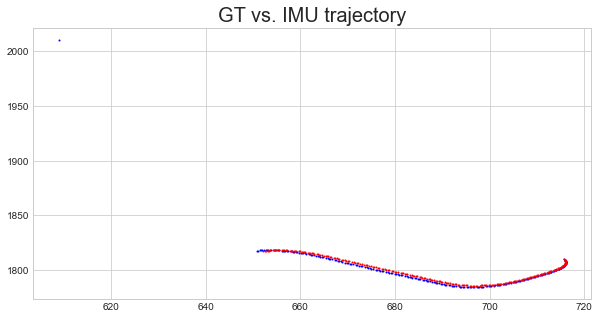

In [4]:

directory = r"C:\Users\gadli\old_pc\Tau\Thesis\nuScenes\v1.0-mini"
scene = 6
dataset = NuscenesDataset(directory=directory,scene=scene)
N = 225
gt = np.zeros((N, 2))
imu = np.zeros((N, 2))
for t in range(0,225):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu[t, :] = trns1[0:2]
    odom = dataset.getOdometry()
    print(odom)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title("GT vs. IMU trajectory", fontsize=20)
ax.scatter(gt[:, 0],gt[:, 1],color='blue',s=1)
ax.scatter(imu[:, 0],imu[:, 1],color='red',s=1)

In [28]:
a = np.zeros((46,46,1))
a.shape[1:]

(46, 1)

In [4]:
from pyquaternion import Quaternion

Quaternion.Inverse()

AttributeError: type object 'Quaternion' has no attribute 'Inverse'